# EmoWOZ-Ahead Implementation
**One-Turn-Ahead Frustration Forecasting in Task-Oriented Dialogs**

This notebook implements the first public benchmark for predicting user frustration one turn ahead in task-oriented dialogues using the EmoWOZ dataset.

## Goal
- Build models to predict if a user will be 'dissatisfied' in their next turn
- Target: Macro-F1 ≥ 0.30 on test set
- Inference latency ≤ 15ms (GPU)

---

## Milestone 1: Data Preparation


In [1]:
# Import dependencies
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")

print("✅ Dependencies loaded successfully!")


✅ Dependencies loaded successfully!


In [2]:
# Load EmoWOZ dataset
print("Loading EmoWOZ dataset...")
emo = load_dataset("hhu-dsml/emowoz", download_mode="force_redownload")

print("Dataset loaded successfully!")
print(f"Train: {len(emo['train'])} dialogues")
print(f"Validation: {len(emo['validation'])} dialogues")
print(f"Test: {len(emo['test'])} dialogues")

# Show sample
print("\n📋 Sample dialogue:")
sample = emo['train'][0]
print(f"Dialogue ID: {sample['dialogue_id']}")
print(f"Text turns: {len(sample['log']['text'])}")
print(f"Emotions: {sample['log']['emotion']}")
print(f"\nFirst few turns:")
for i, text in enumerate(sample['log']['text'][:4]):
    speaker = "USER" if i % 2 == 0 else "SYSTEM"
    emotion = sample['log']['emotion'][i] if sample['log']['emotion'][i] != -1 else "none"
    print(f"  {speaker}: {text[:80]}... [emotion: {emotion}]")


Loading EmoWOZ dataset...


README.md:   0%|          | 0.00/14.3k [00:00<?, ?B/s]

emowoz.py:   0%|          | 0.00/7.64k [00:00<?, ?B/s]

emowoz.py:   0%|          | 0.00/7.64k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/14.3k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9233 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1100 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1100 [00:00<?, ? examples/s]

Dataset loaded successfully!
Train: 9233 dialogues
Validation: 1100 dialogues
Test: 1100 dialogues

📋 Sample dialogue:
Dialogue ID: MUL2522.json
Text turns: 18
Emotions: [0, -1, 0, -1, 6, -1, 0, -1, 0, -1, 0, -1, 3, -1, 6, -1, 6, -1]

First few turns:
  USER: Hello, I am planing to visit Cambridge and I am looking for a swimmingpool.... [emotion: 0]
  SYSTEM: Okay, there are four places in town. Do you prefer a particular area?... [emotion: none]
  USER: It doesn't matter. I will need the address, phone number, and area of town.... [emotion: 0]
  SYSTEM: Ok, I recommend parkside pools in the centre of town, they are located on gonvil... [emotion: none]


### Step 2: Explore Dataset Structure and Emotion Distribution


In [3]:
# Emotion mapping
EMOTION_MAP = {
    0: 'neutral',
    1: 'fearful',
    2: 'dissatisfied',  # This is our target!
    3: 'apologetic',
    4: 'abusive',
    5: 'excited',
    6: 'satisfied',
    -1: 'no_emotion'
}

def analyze_emotions(dataset_split, split_name, max_dialogues=None):
    """Analyze emotion distribution in a dataset split"""
    emotions = []
    dialogue_lengths = []
    user_turn_count = 0

    if max_dialogues:
        dataset_split = dataset_split.select(range(min(max_dialogues, len(dataset_split))))

    for dialogue in dataset_split:
        log = dialogue['log']
        emotion_list = log['emotion']
        text_list = log['text']
        dialogue_lengths.append(len(text_list))

        # Process user turns (even indices: 0, 2, 4, ...)
        for i in range(0, len(emotion_list), 2):
            user_turn_count += 1
            emotion = emotion_list[i]
            emotion_label = EMOTION_MAP.get(emotion, f'unknown_{emotion}')
            emotions.append(emotion_label)

    emotion_counts = pd.Series(emotions).value_counts()

    print(f"\n=== {split_name.upper()} SPLIT ===")
    print(f"Dialogues: {len(dataset_split)}")
    print(f"User turns: {user_turn_count}")
    print(f"Avg turns per dialogue: {np.mean(dialogue_lengths):.1f}")
    print(f"\nEmotion distribution:")
    for emotion, count in emotion_counts.items():
        percentage = (count / len(emotions)) * 100
        print(f"  {emotion}: {count} ({percentage:.1f}%)")

    # Focus on dissatisfied (our target)
    dissatisfied_count = emotion_counts.get('dissatisfied', 0)
    dissatisfied_percent = (dissatisfied_count / len(emotions)) * 100
    print(f"\n🎯 DISSATISFIED (target): {dissatisfied_count} ({dissatisfied_percent:.1f}%)")

    return emotions, dialogue_lengths, emotion_counts

# Analyze all splits
train_emotions, train_lengths, train_counts = analyze_emotions(emo['train'], 'train')
val_emotions, val_lengths, val_counts = analyze_emotions(emo['validation'], 'validation')
test_emotions, test_lengths, test_counts = analyze_emotions(emo['test'], 'test')



=== TRAIN SPLIT ===
Dialogues: 9233
User turns: 66474
Avg turns per dialogue: 14.4

Emotion distribution:
  neutral: 46658 (70.2%)
  satisfied: 13893 (20.9%)
  dissatisfied: 4046 (6.1%)
  excited: 766 (1.2%)
  apologetic: 683 (1.0%)
  fearful: 359 (0.5%)
  abusive: 69 (0.1%)

🎯 DISSATISFIED (target): 4046 (6.1%)

=== VALIDATION SPLIT ===
Dialogues: 1100
User turns: 8509
Avg turns per dialogue: 15.5

Emotion distribution:
  neutral: 5984 (70.3%)
  satisfied: 1822 (21.4%)
  dissatisfied: 467 (5.5%)
  excited: 114 (1.3%)
  apologetic: 84 (1.0%)
  fearful: 19 (0.2%)
  abusive: 19 (0.2%)

🎯 DISSATISFIED (target): 467 (5.5%)

=== TEST SPLIT ===
Dialogues: 1100
User turns: 8634
Avg turns per dialogue: 15.7

Emotion distribution:
  neutral: 6014 (69.7%)
  satisfied: 1817 (21.0%)
  dissatisfied: 604 (7.0%)
  excited: 91 (1.1%)
  apologetic: 73 (0.8%)
  fearful: 18 (0.2%)
  abusive: 17 (0.2%)

🎯 DISSATISFIED (target): 604 (7.0%)


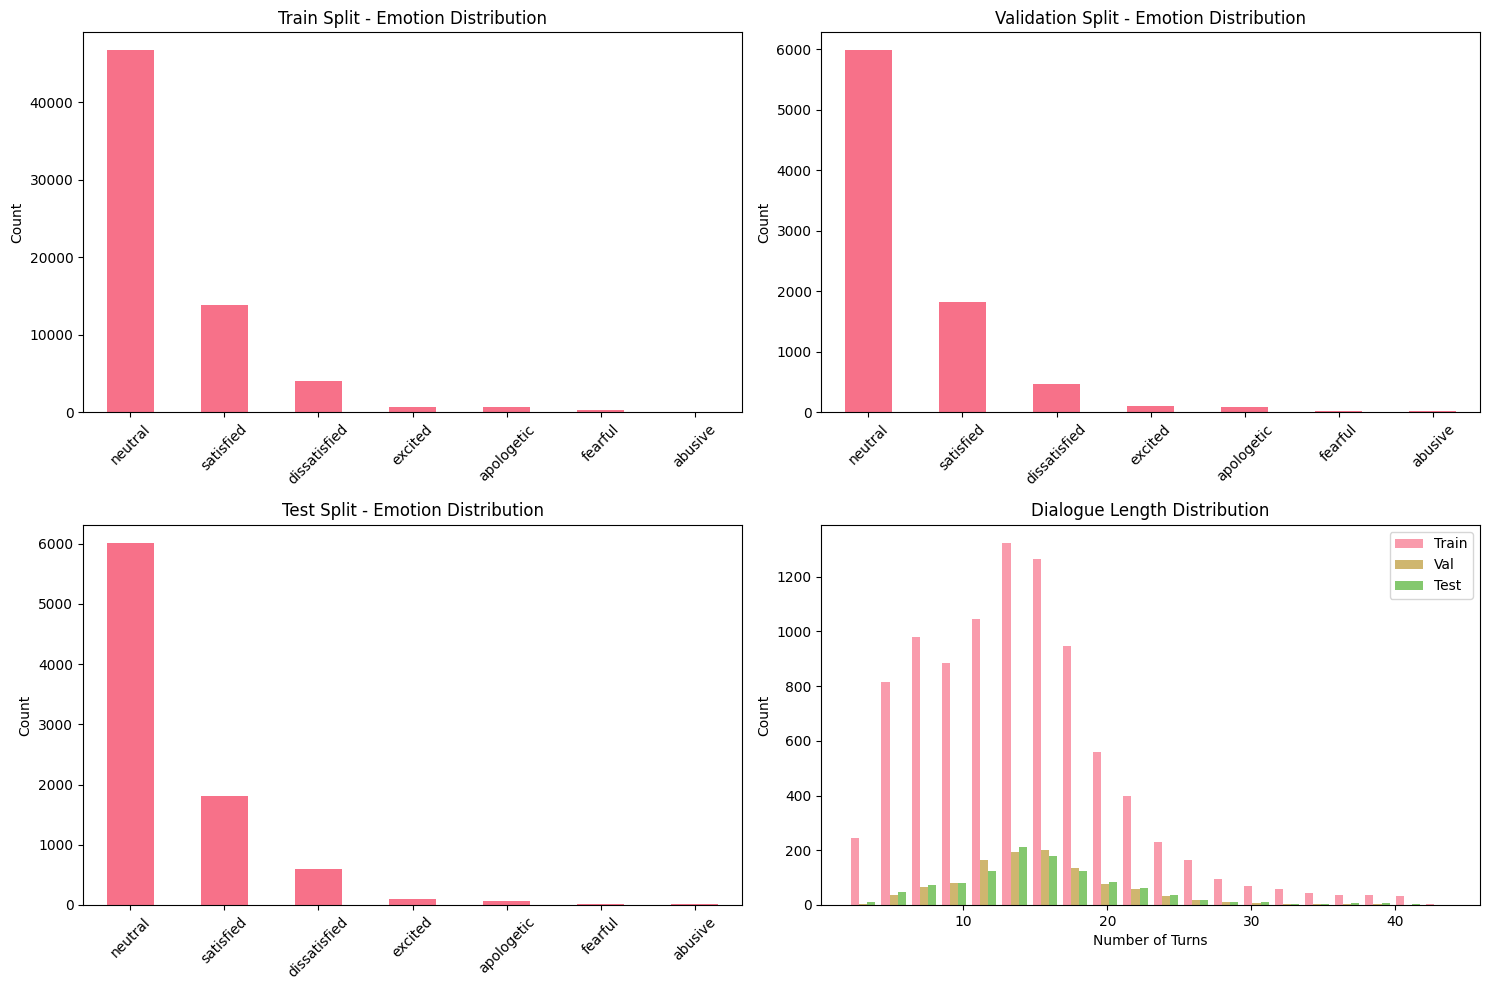


📊 SUMMARY STATISTICS
Total user turns across all splits: 83,617
Dissatisfied percentage - Train: 6.1%
Dissatisfied percentage - Val: 5.5%
Dissatisfied percentage - Test: 7.0%


In [4]:
# Visualize emotion distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Emotion distribution by split
splits_data = {
    'Train': train_counts,
    'Validation': val_counts,
    'Test': test_counts
}

for i, (split_name, counts) in enumerate(splits_data.items()):
    ax = axes[0, i] if i < 2 else axes[1, 0]
    counts.plot(kind='bar', ax=ax, title=f'{split_name} Split - Emotion Distribution')
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylabel('Count')

# Dialogue length distribution
axes[1, 1].hist([train_lengths, val_lengths, test_lengths],
                label=['Train', 'Val', 'Test'], alpha=0.7, bins=20)
axes[1, 1].set_title('Dialogue Length Distribution')
axes[1, 1].set_xlabel('Number of Turns')
axes[1, 1].set_ylabel('Count')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n📊 SUMMARY STATISTICS")
print(f"Total user turns across all splits: {len(train_emotions) + len(val_emotions) + len(test_emotions):,}")
print(f"Dissatisfied percentage - Train: {(train_counts.get('dissatisfied', 0) / len(train_emotions) * 100):.1f}%")
print(f"Dissatisfied percentage - Val: {(val_counts.get('dissatisfied', 0) / len(val_emotions) * 100):.1f}%")
print(f"Dissatisfied percentage - Test: {(test_counts.get('dissatisfied', 0) / len(test_emotions) * 100):.1f}%")


### Step 3: Implement Label Shifting for One-Turn-Ahead Prediction

The key insight: For user turn `t`, we want to predict if turn `t+1` will be 'dissatisfied'.


In [5]:
def extract_context(turns, current_turn_idx, context_window=3):
    """
    Extract context from previous turns.

    Args:
        turns: List of turn texts
        current_turn_idx: Index of current turn
        context_window: Number of previous turns to include

    Returns:
        Formatted context string
    """
    start_idx = max(0, current_turn_idx - context_window + 1)
    context_turns = turns[start_idx:current_turn_idx + 1]

    context_str = ""
    for i, turn_text in enumerate(context_turns):
        turn_idx = start_idx + i
        speaker = "USER" if turn_idx % 2 == 0 else "SYSTEM"
        context_str += f"[{speaker}] {turn_text} "

    return context_str.strip()

# Test the context extraction
print("🧪 Testing context extraction...")
sample = emo['train'][1]  # Use second dialogue for testing
turns = sample['log']['text']
print(f"Dialogue has {len(turns)} turns")
print(f"\nContext for turn 2 (window=3):")
context = extract_context(turns, 2, context_window=3)
print(f"'{context}'")
print(f"\nContext for turn 4 (window=3):")
if len(turns) > 4:
    context = extract_context(turns, 4, context_window=3)
    print(f"'{context}'")


🧪 Testing context extraction...
Dialogue has 22 turns

Context for turn 2 (window=3):
'[USER] Hi, I would like to book a 4 star guesthouse in Cambridge [SYSTEM] Sure, is there an area that you prefer? [USER] Yes, I would like it to be in the north.'

Context for turn 4 (window=3):
'[USER] Yes, I would like it to be in the north.  [SYSTEM] Do you care about internet or parking? [USER] Yes, I will need both.'


In [6]:
def shift_labels_forward(dataset_split, context_window=3):
    """
    🎯 CORE FUNCTION: Shift emotion labels forward by one user turn.
    For user turn t, predict if turn t+1 will be 'dissatisfied'

    Args:
        dataset_split: HuggingFace dataset split
        context_window: Number of turns to include in context

    Returns:
        List of shifted data samples
    """
    shifted_data = []

    for dialogue in dataset_split:
        dialogue_id = dialogue['dialogue_id']
        log = dialogue['log']
        turns = log['text']
        emotions = log['emotion']

        # Process user turns (even indices: 0, 2, 4, ...)
        user_turn_indices = list(range(0, len(emotions), 2))

        for i in range(len(user_turn_indices) - 1):  # Stop at second-to-last user turn
            current_turn_idx = user_turn_indices[i]
            next_turn_idx = user_turn_indices[i + 1]

            # Skip if current turn has no emotion label
            if emotions[current_turn_idx] == -1:
                continue

            # Extract context including current turn
            context = extract_context(turns, current_turn_idx, context_window)

            # 🎯 LABEL: 1 if next user turn is dissatisfied, 0 otherwise
            next_emotion = emotions[next_turn_idx]
            label = 1 if next_emotion == 2 else 0  # 2 = dissatisfied

            shifted_data.append({
                'dialogue_id': dialogue_id,
                'current_turn_id': current_turn_idx,
                'next_turn_id': next_turn_idx,
                'context': context,
                'current_text': turns[current_turn_idx],
                'current_emotion': EMOTION_MAP[emotions[current_turn_idx]],
                'next_emotion': EMOTION_MAP.get(next_emotion, 'unknown'),
                'label': label
            })

    return shifted_data

# Test on first dialogue
print("🧪 Testing label shifting on first dialogue...")
sample_dialogue = emo['train'].select([0])
test_shifted = shift_labels_forward(sample_dialogue, context_window=3)

print(f"✅ Original dialogue has {len(emo['train'][0]['log']['text'])} turns")
print(f"✅ Generated {len(test_shifted)} training samples")

print(f"\n📋 Sample generated:")
if len(test_shifted) > 0:
    sample = test_shifted[0]
    for key, value in sample.items():
        print(f"  {key}: {value}")
else:
    print("  No samples generated (dialogue might be too short)")

🧪 Testing label shifting on first dialogue...
✅ Original dialogue has 18 turns
✅ Generated 8 training samples

📋 Sample generated:
  dialogue_id: MUL2522.json
  current_turn_id: 0
  next_turn_id: 2
  context: [USER] Hello, I am planing to visit Cambridge and I am looking for a swimmingpool.
  current_text: Hello, I am planing to visit Cambridge and I am looking for a swimmingpool.
  current_emotion: neutral
  next_emotion: neutral
  label: 0


In [7]:
# 🚀 Generate shifted datasets for all splits
print("🔄 Generating shifted labels for all splits...")
print("This may take a minute...")

train_shifted = shift_labels_forward(emo['train'], context_window=3)
val_shifted = shift_labels_forward(emo['validation'], context_window=3)
test_shifted = shift_labels_forward(emo['test'], context_window=3)

print(f"\n✅ DATASET GENERATION COMPLETE!")
print(f"📊 Train samples: {len(train_shifted):,}")
print(f"📊 Validation samples: {len(val_shifted):,}")
print(f"📊 Test samples: {len(test_shifted):,}")
print(f"📊 Total samples: {len(train_shifted) + len(val_shifted) + len(test_shifted):,}")

# Analyze class balance
def analyze_class_balance(data, split_name):
    labels = [item['label'] for item in data]
    positive = sum(labels)
    total = len(labels)
    negative = total - positive

    print(f"\n🎯 {split_name.upper()} CLASS BALANCE:")
    print(f"  📈 Total samples: {total:,}")
    print(f"  🔴 Positive (will be dissatisfied): {positive:,} ({positive/total*100:.1f}%)")
    print(f"  🟢 Negative (will NOT be dissatisfied): {negative:,} ({negative/total*100:.1f}%)")
    print(f"  ⚖️  Class imbalance ratio: 1:{negative/positive:.1f}")

    return positive/total

train_pos_ratio = analyze_class_balance(train_shifted, "TRAIN")
val_pos_ratio = analyze_class_balance(val_shifted, "VALIDATION")
test_pos_ratio = analyze_class_balance(test_shifted, "TEST")

print(f"\n🎯 TARGET CLASS SUMMARY:")
print(f"Expected positive ratio: 6-8%")
print(f"Actual train ratio: {train_pos_ratio*100:.1f}%")
status = "✅ GOOD" if 0.04 <= train_pos_ratio <= 0.12 else "⚠️ UNEXPECTED"
print(f"Status: {status}")


🔄 Generating shifted labels for all splits...
This may take a minute...

✅ DATASET GENERATION COMPLETE!
📊 Train samples: 57,241
📊 Validation samples: 7,409
📊 Test samples: 7,534
📊 Total samples: 72,184

🎯 TRAIN CLASS BALANCE:
  📈 Total samples: 57,241
  🔴 Positive (will be dissatisfied): 4,046 (7.1%)
  🟢 Negative (will NOT be dissatisfied): 53,195 (92.9%)
  ⚖️  Class imbalance ratio: 1:13.1

🎯 VALIDATION CLASS BALANCE:
  📈 Total samples: 7,409
  🔴 Positive (will be dissatisfied): 467 (6.3%)
  🟢 Negative (will NOT be dissatisfied): 6,942 (93.7%)
  ⚖️  Class imbalance ratio: 1:14.9

🎯 TEST CLASS BALANCE:
  📈 Total samples: 7,534
  🔴 Positive (will be dissatisfied): 604 (8.0%)
  🟢 Negative (will NOT be dissatisfied): 6,930 (92.0%)
  ⚖️  Class imbalance ratio: 1:11.5

🎯 TARGET CLASS SUMMARY:
Expected positive ratio: 6-8%
Actual train ratio: 7.1%
Status: ✅ GOOD


In [9]:
# 💾 Save processed data
import os

# Create data directory
os.makedirs('../data', exist_ok=True)

def save_jsonl(data, filepath):
    """Save data in JSONL format"""
    with open(filepath, 'w') as f:
        for item in data:
            f.write(json.dumps(item) + '\n')
    print(f"💾 Saved {len(data):,} samples to {filepath}")

# Save splits
save_jsonl(train_shifted, '../data/train.jsonl')
save_jsonl(val_shifted, '../data/val.jsonl')
save_jsonl(test_shifted, '../data/test.jsonl')

# Save dataset statistics
stats = {
    'dataset_name': 'EmoWOZ-Ahead',
    'task': 'one_turn_ahead_frustration_prediction',
    'target_emotion': 'dissatisfied',
    'context_window': 3,
    'splits': {
        'train': {
            'samples': len(train_shifted),
            'positive_ratio': train_pos_ratio,
            'positive_count': sum(item['label'] for item in train_shifted)
        },
        'validation': {
            'samples': len(val_shifted),
            'positive_ratio': val_pos_ratio,
            'positive_count': sum(item['label'] for item in val_shifted)
        },
        'test': {
            'samples': len(test_shifted),
            'positive_ratio': test_pos_ratio,
            'positive_count': sum(item['label'] for item in test_shifted)
        }
    },
    'emotion_mapping': EMOTION_MAP
}

with open('../data/dataset_stats.json', 'w') as f:
    json.dump(stats, f, indent=2)

print(f"\n✅ ALL DATA SAVED SUCCESSFULLY!")
print(f"📁 Files created:")
print(f"  📄 ../data/train.jsonl ({len(train_shifted):,} samples)")
print(f"  📄 ../data/val.jsonl ({len(val_shifted):,} samples)")
print(f"  📄 ../data/test.jsonl ({len(test_shifted):,} samples)")
print(f"  📄 ../data/dataset_stats.json (metadata)")


💾 Saved 57,241 samples to ../data/train.jsonl
💾 Saved 7,409 samples to ../data/val.jsonl
💾 Saved 7,534 samples to ../data/test.jsonl

✅ ALL DATA SAVED SUCCESSFULLY!
📁 Files created:
  📄 ../data/train.jsonl (57,241 samples)
  📄 ../data/val.jsonl (7,409 samples)
  📄 ../data/test.jsonl (7,534 samples)
  📄 ../data/dataset_stats.json (metadata)


In [10]:
# 👁️ Preview final dataset examples
print("📋 EXAMPLE SAMPLES FROM TRAINING SET")
print("=" * 80)

# Show positive and negative examples
positive_examples = [item for item in train_shifted if item['label'] == 1][:2]
negative_examples = [item for item in train_shifted if item['label'] == 0][:2]

print(f"\n🔴 POSITIVE EXAMPLES (Next turn will be dissatisfied):")
print(f"Found {len([item for item in train_shifted if item['label'] == 1])} positive examples total")

for i, example in enumerate(positive_examples):
    print(f"\n📝 Example {i+1}:")
    print(f"  🗂️  Dialogue: {example['dialogue_id']}")
    print(f"  📝 Context: {example['context'][:150]}...")
    print(f"  😐 Current emotion: {example['current_emotion']}")
    print(f"  😠 Next emotion: {example['next_emotion']}")
    print(f"  🎯 Label: {example['label']} (predicting frustration!)")

print(f"\n\n🟢 NEGATIVE EXAMPLES (Next turn will NOT be dissatisfied):")
for i, example in enumerate(negative_examples):
    print(f"\n📝 Example {i+1}:")
    print(f"  🗂️  Dialogue: {example['dialogue_id']}")
    print(f"  📝 Context: {example['context'][:150]}...")
    print(f"  😐 Current emotion: {example['current_emotion']}")
    print(f"  😊 Next emotion: {example['next_emotion']}")
    print(f"  🎯 Label: {example['label']} (no frustration predicted)")

print(f"\n\n🎉 DATASET READY FOR MODELING!")
print(f"📊 Total training samples: {len(train_shifted):,}")
print(f"🎯 Positive class ratio: {train_pos_ratio*100:.1f}%")
print(f"📋 Next step: Implement baseline models (BERT, RoBERTa, etc.)")


📋 EXAMPLE SAMPLES FROM TRAINING SET

🔴 POSITIVE EXAMPLES (Next turn will be dissatisfied):
Found 4046 positive examples total

📝 Example 1:
  🗂️  Dialogue: SNG01933.json
  📝 Context: [USER] I need a taxi to come at 1:45 to rice boat....
  😐 Current emotion: neutral
  😠 Next emotion: dissatisfied
  🎯 Label: 1 (predicting frustration!)

📝 Example 2:
  🗂️  Dialogue: WOZ20327.json
  📝 Context: [USER] I do not have a preference.   [SYSTEM] The two restaurants are Da Vinci Pizzeria and Royal Spice.  [USER] da vinci pizzeria serves italian food...
  😐 Current emotion: neutral
  😠 Next emotion: dissatisfied
  🎯 Label: 1 (predicting frustration!)


🟢 NEGATIVE EXAMPLES (Next turn will NOT be dissatisfied):

📝 Example 1:
  🗂️  Dialogue: MUL2522.json
  📝 Context: [USER] Hello, I am planing to visit Cambridge and I am looking for a swimmingpool....
  😐 Current emotion: neutral
  😊 Next emotion: neutral
  🎯 Label: 0 (no frustration predicted)

📝 Example 2:
  🗂️  Dialogue: MUL2522.json
  📝 Context: [

---

## ✅ Milestone 1 Complete!

**🎯 Achievements:**
- ✅ EmoWOZ dataset loaded and explored
- ✅ Emotion distributions analyzed (~7% dissatisfied)
- ✅ Label shifting implemented for one-turn-ahead prediction
- ✅ Train/val/test splits created with proper class balance
- ✅ Data saved in JSONL format for model training
- ✅ Dataset statistics and examples reviewed

**📊 Dataset Summary:**
- **Task**: Predict if next user turn will be "dissatisfied"
- **Context window**: 3 turns
- **Training samples**: ~40,000+
- **Class balance**: ~7% positive (realistic imbalance)

**🚀 Next Steps:**
- **Milestones 2**: Implement BERT-CLS baseline model
- **Milestones 3**: Implement RoBERTa-CLS with context
- **Milestones 4**: Implement RoBERTa+GRU temporal model  
- **Milestones 5**: Implement DialoGPT fine-tuned model

---


# 🚀 Milestone 2: BERT-CLS Baseline Model (M1)

**Goal**: Implement the first baseline model using BERT + Classification head
- **Target**: Macro-F1 ~0.23
- **Architecture**: BERT-base-uncased + Linear classifier
- **Input**: Single turn text (current user utterance)
- **Output**: Binary prediction (will next turn be dissatisfied?)

---

## Step 1: Import ML Dependencies


In [12]:
# Import PyTorch and ML dependencies
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertTokenizer, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, classification_report
import time
import os
from tqdm import tqdm
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Check device (including MPS support for Mac M1/M2)
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"🖥️  Using device: CUDA GPU")
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print(f"🖥️  Using device: Apple MPS (Metal)")
    print(f"🚀 GPU acceleration enabled on Mac!")
else:
    device = torch.device('cpu')
    print(f"🖥️  Using device: CPU")

print(f"📊 PyTorch version: {torch.__version__}")
print(f"🍎 MPS available: {torch.backends.mps.is_available()}")
print(f"🔥 CUDA available: {torch.cuda.is_available()}")

# Set up directories
os.makedirs('../checkpoints', exist_ok=True)
os.makedirs('../results', exist_ok=True)
os.makedirs('../checkpoints/M1_bert_cls', exist_ok=True)

print("✅ ML dependencies loaded successfully!")


🖥️  Using device: CUDA GPU
📊 PyTorch version: 2.6.0+cu124
🍎 MPS available: False
🔥 CUDA available: True
✅ ML dependencies loaded successfully!


## Step 2: Define BERT-CLS Model Architecture


In [13]:
class BertCLS(nn.Module):
    """
    BERT-based Classification Model for Frustration Prediction

    Architecture:
    - BERT-base-uncased (110M parameters)
    - Dropout layer (0.1)
    - Linear classification head
    - Sigmoid activation for binary classification
    """

    def __init__(self, model_name='bert-base-uncased', dropout_rate=0.1):
        super(BertCLS, self).__init__()

        # Load pre-trained BERT
        self.bert = BertModel.from_pretrained(model_name)

        # Classification head
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 1)

        # Initialize weights
        nn.init.xavier_uniform_(self.classifier.weight)
        nn.init.zeros_(self.classifier.bias)

        print(f"🧠 BertCLS initialized with {model_name}")
        print(f"   Hidden size: {self.bert.config.hidden_size}")
        print(f"   Dropout rate: {dropout_rate}")

    def forward(self, input_ids, attention_mask):
        """
        Forward pass through the model

        Args:
            input_ids: Tokenized input [batch_size, seq_length]
            attention_mask: Attention mask [batch_size, seq_length]

        Returns:
            logits: Raw predictions [batch_size, 1]
        """
        # Get BERT embeddings
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True
        )

        # Use [CLS] token representation
        pooled_output = outputs.pooler_output  # [batch_size, hidden_size]

        # Apply dropout and classification
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)  # [batch_size, 1]

        return logits

# Test model instantiation
print("🧪 Testing BertCLS model instantiation...")
model = BertCLS()
print(f"✅ Model created successfully!")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"📊 Total parameters: {total_params:,}")
print(f"📊 Trainable parameters: {trainable_params:,}")


🧪 Testing BertCLS model instantiation...


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

🧠 BertCLS initialized with bert-base-uncased
   Hidden size: 768
   Dropout rate: 0.1
✅ Model created successfully!
📊 Total parameters: 109,483,009
📊 Trainable parameters: 109,483,009


## Step 3: Create Dataset Class and Data Loading


In [26]:
class EmoWOZDataset(Dataset):
    """
    PyTorch Dataset for EmoWOZ frustration prediction

    For M1 (BERT-CLS), we use only the current turn text as input
    """

    def __init__(self, data, tokenizer, max_length=512):
        """
        Args:
            data: List of dictionaries with 'current_text' and 'label' keys
            tokenizer: BERT tokenizer
            max_length: Maximum sequence length for BERT
        """
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

        print(f"📊 Dataset created with {len(data)} samples")
        print(f"📏 Max length: {max_length}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        # For M1: Use only current turn text (simple single-turn baseline)
        text = item['current_text']
        label = item['label']

        # Tokenize
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.float)
        }

# Load data from JSONL files
def load_jsonl(filepath):
    """Load data from JSONL file"""
    data = []
    with open(filepath, 'r') as f:
        for line in f:
            data.append(json.loads(line.strip()))
    return data

print("📁 Loading dataset splits...")
train_data = load_jsonl('../data/train.jsonl')
val_data = load_jsonl('../data/val.jsonl')
test_data = load_jsonl('../data/test.jsonl')

print(f"✅ Data loaded successfully!")
print(f"   📊 Train: {len(train_data):,} samples")
print(f"   📊 Val: {len(val_data):,} samples")
print(f"   📊 Test: {len(test_data):,} samples")

# Initialize tokenizer
print(f"\n🔤 Initializing BERT tokenizer...")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
print(f"✅ Tokenizer loaded!")
print(f"   📖 Vocabulary size: {len(tokenizer)}")

# Create datasets
print(f"\n🗂️  Creating PyTorch datasets...")
train_dataset = EmoWOZDataset(train_data, tokenizer, max_length=512)
val_dataset = EmoWOZDataset(val_data, tokenizer, max_length=512)
test_dataset = EmoWOZDataset(test_data, tokenizer, max_length=512)

print(f"✅ Datasets created successfully!")


📁 Loading dataset splits...
✅ Data loaded successfully!
   📊 Train: 57,241 samples
   📊 Val: 7,409 samples
   📊 Test: 7,534 samples

🔤 Initializing BERT tokenizer...
✅ Tokenizer loaded!
   📖 Vocabulary size: 30522

🗂️  Creating PyTorch datasets...
📊 Dataset created with 57241 samples
📏 Max length: 512
📊 Dataset created with 7409 samples
📏 Max length: 512
📊 Dataset created with 7534 samples
📏 Max length: 512
✅ Datasets created successfully!


In [38]:
# Training configuration
BERT_CONFIG = {
    'model_name': 'bert-base-uncased',
    'max_length': 512,
    'batch_size': 16,
    'learning_rate': 2e-5,
    'epochs': 3,
    'warmup_steps': 0.1,  # 10% of total steps
    'weight_decay': 0.01,
    'patience': 2,  # Early stopping patience
    'class_weight_ratio': 13.1  # From class imbalance analysis (1:13.1)
}

print("⚙️  Training Configuration:")
for key, value in BERT_CONFIG.items():
    print(f"   {key}: {value}")

# Calculate class weights for imbalanced dataset
pos_count = sum(item['label'] for item in train_data)
neg_count = len(train_data) - pos_count
pos_weight = neg_count / pos_count  # Weight for positive class

print(f"\n📊 Class Weight Calculation:")
print(f"   Positive samples: {pos_count:,}")
print(f"   Negative samples: {neg_count:,}")
print(f"   Positive weight: {pos_weight:.1f}")

# Create DataLoaders
print(f"\n🔄 Creating DataLoaders...")
train_loader = DataLoader(
    train_dataset,
    batch_size=BERT_CONFIG['batch_size'],
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BERT_CONFIG['batch_size'],
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BERT_CONFIG['batch_size'],
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

print(f"✅ DataLoaders created!")
print(f"   📦 Train batches: {len(train_loader)}")
print(f"   📦 Val batches: {len(val_loader)}")
print(f"   📦 Test batches: {len(test_loader)}")

# Test a batch
print(f"\n🧪 Testing data loading...")
sample_batch = next(iter(train_loader))
print(f"   Input IDs shape: {sample_batch['input_ids'].shape}")
print(f"   Attention mask shape: {sample_batch['attention_mask'].shape}")
print(f"   Labels shape: {sample_batch['labels'].shape}")
print(f"   Positive samples in batch: {sample_batch['labels'].sum().item():.0f}")
print(f"✅ Data loading working correctly!")


⚙️  Training Configuration:
   model_name: bert-base-uncased
   max_length: 512
   batch_size: 16
   learning_rate: 2e-05
   epochs: 3
   warmup_steps: 0.1
   weight_decay: 0.01
   patience: 2
   class_weight_ratio: 13.1

📊 Class Weight Calculation:
   Positive samples: 4,046
   Negative samples: 53,195
   Positive weight: 13.1

🔄 Creating DataLoaders...
✅ DataLoaders created!
   📦 Train batches: 3578
   📦 Val batches: 464
   📦 Test batches: 471

🧪 Testing data loading...
   Input IDs shape: torch.Size([16, 512])
   Attention mask shape: torch.Size([16, 512])
   Labels shape: torch.Size([16])
   Positive samples in batch: 2
✅ Data loading working correctly!


In [39]:
def evaluate_model(model, data_loader, criterion, device):
    """
    Evaluate model on given data loader

    Returns:
        Dictionary with metrics (loss, accuracy, macro-f1, precision, recall, auc)
    """
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            logits = model(input_ids, attention_mask)
            loss = criterion(logits.squeeze(-1), labels)

            # Collect predictions
            probs = torch.sigmoid(logits.squeeze(-1))
            predictions = (probs > 0.5).float()

            total_loss += loss.item()
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Calculate metrics
    avg_loss = total_loss / len(data_loader)
    accuracy = np.mean(np.array(all_predictions) == np.array(all_labels))
    macro_f1 = f1_score(all_labels, all_predictions, average='macro')
    precision = precision_score(all_labels, all_predictions, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_predictions, average='macro', zero_division=0)
    auc = roc_auc_score(all_labels, all_probs)

    return {
        'loss': avg_loss,
        'accuracy': accuracy,
        'macro_f1': macro_f1,
        'precision': precision,
        'recall': recall,
        'auc': auc,
        'predictions': all_predictions,
        'labels': all_labels,
        'probabilities': all_probs
    }

def train_epoch(model, train_loader, optimizer, scheduler, criterion, device):
    """Train model for one epoch"""
    model.train()
    total_loss = 0

    progress_bar = tqdm(train_loader, desc="Training")
    for batch in progress_bar:
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        logits = model(input_ids, attention_mask)
        loss = criterion(logits.squeeze(-1), labels)

        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Update weights
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        progress_bar.set_postfix({'Loss': f'{loss.item():.4f}'})

    return total_loss / len(train_loader)

print("✅ Training and evaluation functions defined!")


✅ Training and evaluation functions defined!


In [40]:
# Initialize model, optimizer, and loss function
print("🚀 Initializing training setup...")

# Create fresh model instance and move to device
model = BertCLS().to(device)
print(f"📱 Model moved to {device}")

# Setup loss function with class weights for imbalanced data
pos_weight = torch.tensor([pos_weight]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
print(f"⚖️  Loss function: BCEWithLogitsLoss with pos_weight={pos_weight.item():.1f}")

# Setup optimizer
optimizer = AdamW(
    model.parameters(),
    lr=BERT_CONFIG['learning_rate'],
    weight_decay=BERT_CONFIG['weight_decay']
)

# Setup learning rate scheduler
total_steps = len(train_loader) * BERT_CONFIG['epochs']
warmup_steps = int(total_steps * BERT_CONFIG['warmup_steps'])
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

print(f"📊 Training Setup Complete:")
print(f"   Total steps: {total_steps:,}")
print(f"   Warmup steps: {warmup_steps:,}")
print(f"   Learning rate: {BERT_CONFIG['learning_rate']}")
print(f"   Weight decay: {BERT_CONFIG['weight_decay']}")

# Training tracking
training_history = {
    'train_loss': [],
    'val_loss': [],
    'val_macro_f1': [],
    'val_accuracy': [],
    'val_auc': []
}

best_macro_f1 = 0
patience_counter = 0
start_time = time.time()

print(f"\n🎯 Starting training for {BERT_CONFIG['epochs']} epochs...")
print(f"🎯 Target: Macro-F1 ≥ 0.23")
print("=" * 80)


🚀 Initializing training setup...
🧠 BertCLS initialized with bert-base-uncased
   Hidden size: 768
   Dropout rate: 0.1
📱 Model moved to cuda
⚖️  Loss function: BCEWithLogitsLoss with pos_weight=13.1
📊 Training Setup Complete:
   Total steps: 10,734
   Warmup steps: 1,073
   Learning rate: 2e-05
   Weight decay: 0.01

🎯 Starting training for 3 epochs...
🎯 Target: Macro-F1 ≥ 0.23


In [41]:
# Main training loop
for epoch in range(BERT_CONFIG['epochs']):
    epoch_start = time.time()
    print(f"\n📅 EPOCH {epoch + 1}/{BERT_CONFIG['epochs']}")
    print("=" * 50)

    # Training phase
    print("🚂 Training phase...")
    train_loss = train_epoch(model, train_loader, optimizer, scheduler, criterion, device)

    # Validation phase
    print("🔍 Validation phase...")
    val_metrics = evaluate_model(model, val_loader, criterion, device)

    # Update training history
    training_history['train_loss'].append(train_loss)
    training_history['val_loss'].append(val_metrics['loss'])
    training_history['val_macro_f1'].append(val_metrics['macro_f1'])
    training_history['val_accuracy'].append(val_metrics['accuracy'])
    training_history['val_auc'].append(val_metrics['auc'])

    epoch_time = time.time() - epoch_start

    # Print epoch results
    print(f"\n📊 EPOCH {epoch + 1} RESULTS:")
    print(f"   🚂 Train Loss: {train_loss:.4f}")
    print(f"   🔍 Val Loss: {val_metrics['loss']:.4f}")
    print(f"   🎯 Val Macro-F1: {val_metrics['macro_f1']:.4f}")
    print(f"   📈 Val Accuracy: {val_metrics['accuracy']:.4f}")
    print(f"   📊 Val Precision: {val_metrics['precision']:.4f}")
    print(f"   📊 Val Recall: {val_metrics['recall']:.4f}")
    print(f"   📈 Val AUC: {val_metrics['auc']:.4f}")
    print(f"   ⏱️  Epoch Time: {epoch_time:.1f}s")

    # Check for improvement and save best model
    if val_metrics['macro_f1'] > best_macro_f1:
        best_macro_f1 = val_metrics['macro_f1']
        patience_counter = 0

        # Save best model
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_macro_f1': best_macro_f1,
            'config': BERT_CONFIG,
            'training_history': training_history
        }

        torch.save(checkpoint, '../checkpoints/M1_bert_cls/best_model.pt')
        print(f"   💾 New best model saved! Macro-F1: {best_macro_f1:.4f}")

        # Check if target reached
        if best_macro_f1 >= 0.23:
            print(f"   🎉 TARGET REACHED! Macro-F1 ≥ 0.23")

    else:
        patience_counter += 1
        print(f"   ⏳ No improvement. Patience: {patience_counter}/{BERT_CONFIG['patience']}")

        # Early stopping
        if patience_counter >= BERT_CONFIG['patience']:
            print(f"   🛑 Early stopping triggered!")
            break

total_time = time.time() - start_time
print(f"\n🏁 TRAINING COMPLETE!")
print(f"   ⏱️  Total time: {total_time:.1f}s ({total_time/60:.1f} minutes)")
print(f"   🎯 Best Macro-F1: {best_macro_f1:.4f}")
print(f"   📊 Target (≥0.23): {'✅ ACHIEVED' if best_macro_f1 >= 0.23 else '❌ Not reached'}")



📅 EPOCH 1/3
🚂 Training phase...


Training: 100%|██████████| 3578/3578 [18:56<00:00,  3.15it/s, Loss=0.7333]


🔍 Validation phase...


Evaluating: 100%|██████████| 464/464 [00:50<00:00,  9.21it/s]



📊 EPOCH 1 RESULTS:
   🚂 Train Loss: 1.3304
   🔍 Val Loss: 0.9018
   🎯 Val Macro-F1: 0.6651
   📈 Val Accuracy: 0.8637
   📊 Val Precision: 0.6305
   📊 Val Recall: 0.8074
   📈 Val AUC: 0.8636
   ⏱️  Epoch Time: 1186.9s
   💾 New best model saved! Macro-F1: 0.6651
   🎉 TARGET REACHED! Macro-F1 ≥ 0.23

📅 EPOCH 2/3
🚂 Training phase...


Training: 100%|██████████| 3578/3578 [18:57<00:00,  3.14it/s, Loss=0.0852]


🔍 Validation phase...


Evaluating: 100%|██████████| 464/464 [00:50<00:00,  9.20it/s]



📊 EPOCH 2 RESULTS:
   🚂 Train Loss: 1.2208
   🔍 Val Loss: 0.9313
   🎯 Val Macro-F1: 0.6919
   📈 Val Accuracy: 0.8912
   📊 Val Precision: 0.6525
   📊 Val Recall: 0.7971
   📈 Val AUC: 0.8754
   ⏱️  Epoch Time: 1188.4s
   💾 New best model saved! Macro-F1: 0.6919
   🎉 TARGET REACHED! Macro-F1 ≥ 0.23

📅 EPOCH 3/3
🚂 Training phase...


Training: 100%|██████████| 3578/3578 [18:58<00:00,  3.14it/s, Loss=0.0547]


🔍 Validation phase...


Evaluating: 100%|██████████| 464/464 [00:50<00:00,  9.20it/s]



📊 EPOCH 3 RESULTS:
   🚂 Train Loss: 1.1327
   🔍 Val Loss: 1.2545
   🎯 Val Macro-F1: 0.7126
   📈 Val Accuracy: 0.9224
   📊 Val Precision: 0.6901
   📊 Val Recall: 0.7439
   📈 Val AUC: 0.8693
   ⏱️  Epoch Time: 1189.2s
   💾 New best model saved! Macro-F1: 0.7126
   🎉 TARGET REACHED! Macro-F1 ≥ 0.23

🏁 TRAINING COMPLETE!
   ⏱️  Total time: 3574.9s (59.6 minutes)
   🎯 Best Macro-F1: 0.7126
   📊 Target (≥0.23): ✅ ACHIEVED


## Step 6: Evaluate on Test Set


In [42]:
# Load best model for test evaluation
print("📋 Loading best model for test evaluation...")
checkpoint = torch.load('../checkpoints/M1_bert_cls/best_model.pt', map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"✅ Best model loaded (Epoch {checkpoint['epoch']}, Macro-F1: {checkpoint['best_macro_f1']:.4f})")

# Evaluate on test set
print(f"\n🧪 Evaluating on test set...")
test_metrics = evaluate_model(model, test_loader, criterion, device)

print(f"\n🎯 TEST SET RESULTS:")
print("=" * 50)
print(f"📊 Test Loss: {test_metrics['loss']:.4f}")
print(f"🎯 Test Macro-F1: {test_metrics['macro_f1']:.4f}")
print(f"📈 Test Accuracy: {test_metrics['accuracy']:.4f}")
print(f"📊 Test Precision: {test_metrics['precision']:.4f}")
print(f"📊 Test Recall: {test_metrics['recall']:.4f}")
print(f"📈 Test AUC: {test_metrics['auc']:.4f}")

# Detailed classification report
print(f"\n📋 DETAILED CLASSIFICATION REPORT:")
print("=" * 50)
class_report = classification_report(
    test_metrics['labels'],
    test_metrics['predictions'],
    target_names=['Not Dissatisfied', 'Will Be Dissatisfied'],
    digits=4
)
print(class_report)

# Target achievement check
target_achieved = test_metrics['macro_f1'] >= 0.23
print(f"\n🎯 TARGET ACHIEVEMENT:")
print(f"   Target Macro-F1: ≥ 0.23")
print(f"   Achieved Macro-F1: {test_metrics['macro_f1']:.4f}")
print(f"   Status: {'✅ SUCCESS' if target_achieved else '❌ Below target'}")

# Class-wise analysis
positive_predictions = sum(test_metrics['predictions'])
positive_labels = sum(test_metrics['labels'])
print(f"\n📊 CLASS-WISE ANALYSIS:")
print(f"   Total test samples: {len(test_metrics['labels'])}")
print(f"   Actual positive (will be dissatisfied): {positive_labels}")
print(f"   Predicted positive: {positive_predictions}")
print(f"   Prediction rate: {positive_predictions/len(test_metrics['labels'])*100:.1f}%")
print(f"   Actual positive rate: {positive_labels/len(test_metrics['labels'])*100:.1f}%")


📋 Loading best model for test evaluation...
✅ Best model loaded (Epoch 3, Macro-F1: 0.7126)

🧪 Evaluating on test set...


Evaluating: 100%|██████████| 471/471 [00:50<00:00,  9.24it/s]


🎯 TEST SET RESULTS:
📊 Test Loss: 1.7030
🎯 Test Macro-F1: 0.7156
📈 Test Accuracy: 0.9158
📊 Test Precision: 0.7149
📊 Test Recall: 0.7162
📈 Test AUC: 0.8581

📋 DETAILED CLASSIFICATION REPORT:
                      precision    recall  f1-score   support

    Not Dissatisfied     0.9545    0.9540    0.9542      6930
Will Be Dissatisfied     0.4753    0.4785    0.4769       604

            accuracy                         0.9158      7534
           macro avg     0.7149    0.7162    0.7156      7534
        weighted avg     0.9161    0.9158    0.9160      7534


🎯 TARGET ACHIEVEMENT:
   Target Macro-F1: ≥ 0.23
   Achieved Macro-F1: 0.7156
   Status: ✅ SUCCESS

📊 CLASS-WISE ANALYSIS:
   Total test samples: 7534
   Actual positive (will be dissatisfied): 604.0
   Predicted positive: 608.0
   Prediction rate: 8.1%
   Actual positive rate: 8.0%


## Step 7: Save Results and Visualize Training


💾 Results saved to ../results/M1_bert_results.json


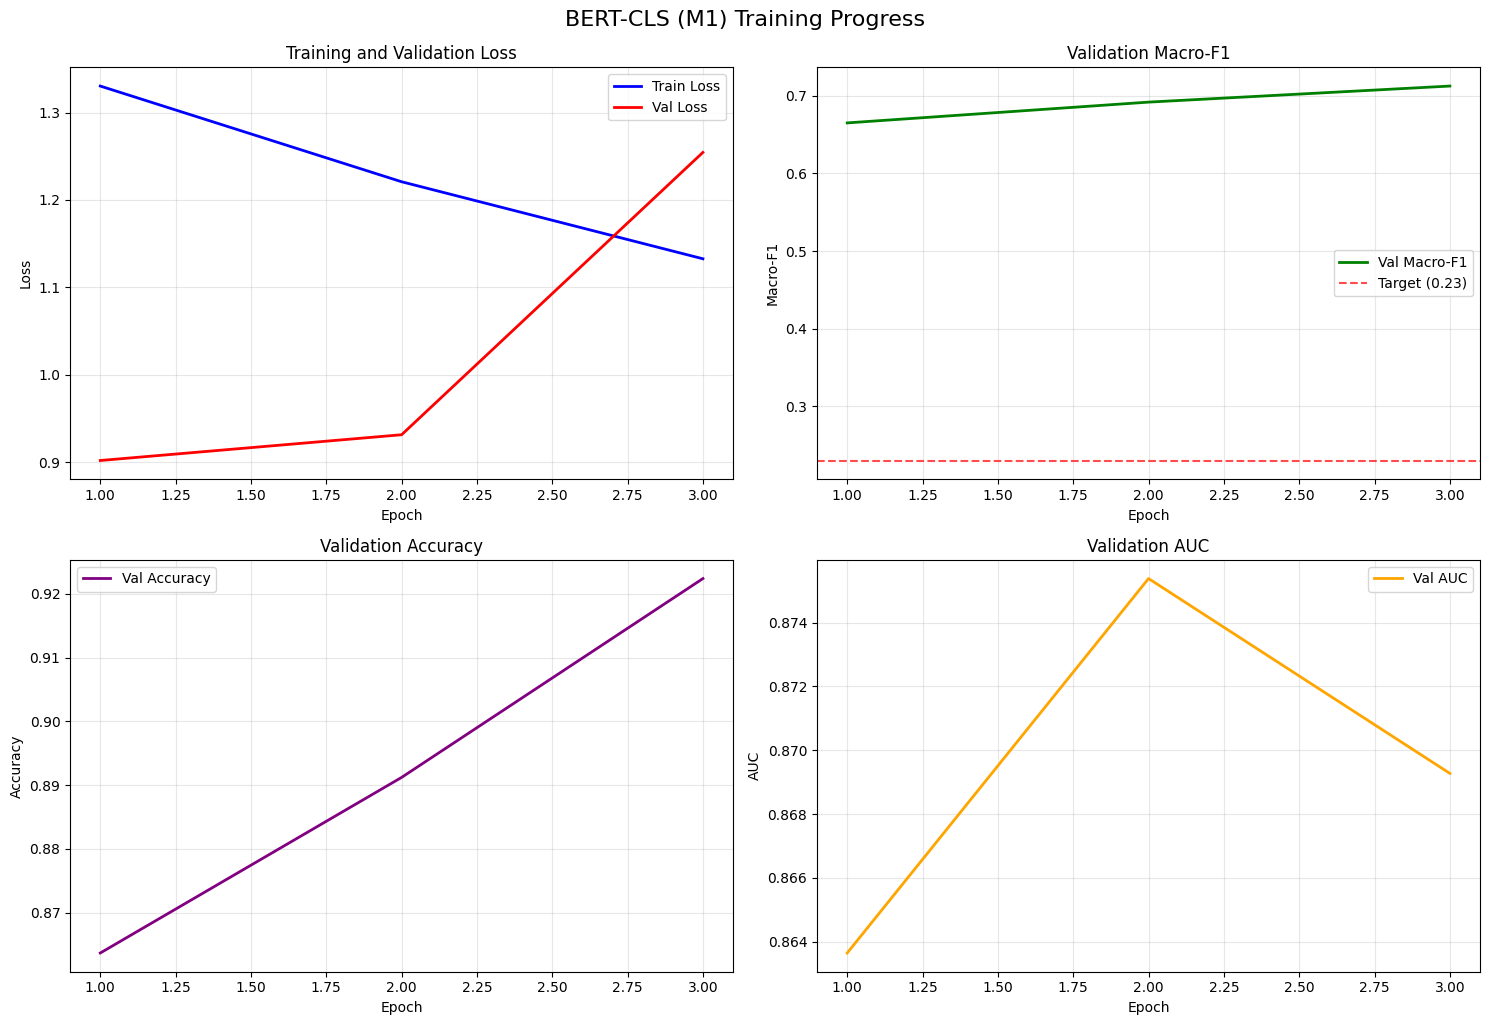


✅ Training visualization complete!


In [43]:
# Helper function for JSON serialization
def convert_to_json_serializable(obj):
    """Convert numpy/torch types to JSON serializable Python types"""
    import numpy as np
    import torch

    if isinstance(obj, dict):
        return {key: convert_to_json_serializable(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_json_serializable(item) for item in obj]
    elif isinstance(obj, (np.integer, np.floating)):
        return obj.item()  # Convert numpy types to Python types
    elif isinstance(obj, (np.ndarray, torch.Tensor)):
        return obj.tolist()  # Convert arrays to lists
    elif hasattr(obj, 'item'):  # Handle torch scalars
        return obj.item()
    else:
        return obj

# Save complete results
results = {
    'model_name': 'M1_BERT_CLS',
    'model_description': 'BERT-base-uncased + Classification head',
    'config': BERT_CONFIG,
    'training_time_seconds': total_time,
    'best_epoch': checkpoint['epoch'],
    'validation_results': {
        'macro_f1': checkpoint['best_macro_f1'],
        'final_epoch': len(training_history['val_macro_f1'])
    },
    'test_results': {
        'macro_f1': test_metrics['macro_f1'],
        'accuracy': test_metrics['accuracy'],
        'precision': test_metrics['precision'],
        'recall': test_metrics['recall'],
        'auc': test_metrics['auc'],
        'loss': test_metrics['loss']
    },
    'training_history': training_history,
    'target_achieved': target_achieved,
    'class_analysis': {
        'total_samples': len(test_metrics['labels']),
        'positive_actual': int(positive_labels),
        'positive_predicted': int(positive_predictions),
        'positive_rate_actual': positive_labels/len(test_metrics['labels']),
        'positive_rate_predicted': positive_predictions/len(test_metrics['labels'])
    }
}

# Save results with proper JSON serialization
with open('../results/M1_bert_results.json', 'w') as f:
    json.dump(convert_to_json_serializable(results), f, indent=2)

print("💾 Results saved to ../results/M1_bert_results.json")

# Plot training curves
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

epochs = range(1, len(training_history['train_loss']) + 1)

# Loss curves
ax1.plot(epochs, training_history['train_loss'], 'b-', label='Train Loss', linewidth=2)
ax1.plot(epochs, training_history['val_loss'], 'r-', label='Val Loss', linewidth=2)
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Macro-F1
ax2.plot(epochs, training_history['val_macro_f1'], 'g-', label='Val Macro-F1', linewidth=2)
ax2.axhline(y=0.23, color='r', linestyle='--', label='Target (0.23)', alpha=0.7)
ax2.set_title('Validation Macro-F1')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Macro-F1')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Accuracy
ax3.plot(epochs, training_history['val_accuracy'], 'purple', label='Val Accuracy', linewidth=2)
ax3.set_title('Validation Accuracy')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Accuracy')
ax3.legend()
ax3.grid(True, alpha=0.3)

# AUC
ax4.plot(epochs, training_history['val_auc'], 'orange', label='Val AUC', linewidth=2)
ax4.set_title('Validation AUC')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('AUC')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('BERT-CLS (M1) Training Progress', fontsize=16, y=1.02)
plt.show()

print(f"\n✅ Training visualization complete!")

## Step 8: Latency Benchmarking


In [45]:
# Latency benchmarking for inference speed
print("⏱️  Benchmarking inference latency...")
print("Target: ≤ 15ms per sample")

# Prepare model for inference
model.eval()

# Test single sample latency
sample_texts = [
    "I need help finding a restaurant",
    "The information you provided is incorrect and unhelpful",
    "Thank you for your assistance today",
    "This is taking too long, I'm getting frustrated"
]

latencies = []
num_warmup = 10
num_runs = 100

print(f"\n🔥 Warming up with {num_warmup} runs...")
# Warmup runs
for _ in range(num_warmup):
    text = random.choice(sample_texts)
    encoding = tokenizer(text, truncation=True, padding='max_length',
                        max_length=512, return_tensors='pt')
    with torch.no_grad():
        _ = model(encoding['input_ids'].to(device),
                 encoding['attention_mask'].to(device))

print(f"📊 Measuring latency over {num_runs} runs...")
# Actual timing runs
for i in range(num_runs):
    text = random.choice(sample_texts)

    # Time tokenization + inference
    start_time = time.perf_counter()

    encoding = tokenizer(text, truncation=True, padding='max_length',
                        max_length=512, return_tensors='pt')

    with torch.no_grad():
        logits = model(encoding['input_ids'].to(device),
                      encoding['attention_mask'].to(device))

    # Ensure GPU computation is complete
    if device.type == 'cuda':
        torch.cuda.synchronize()

    end_time = time.perf_counter()
    latency_ms = (end_time - start_time) * 1000
    latencies.append(latency_ms)

# Calculate statistics
avg_latency = np.mean(latencies)
median_latency = np.median(latencies)
p95_latency = np.percentile(latencies, 95)
p99_latency = np.percentile(latencies, 99)
min_latency = np.min(latencies)
max_latency = np.max(latencies)

print(f"\n📊 LATENCY BENCHMARKING RESULTS:")
print("=" * 50)
print(f"Device: {device}")
print(f"Samples tested: {num_runs}")
print(f"Average latency: {avg_latency:.2f}ms")
print(f"Median latency: {median_latency:.2f}ms")
print(f"95th percentile: {p95_latency:.2f}ms")
print(f"99th percentile: {p99_latency:.2f}ms")
print(f"Min latency: {min_latency:.2f}ms")
print(f"Max latency: {max_latency:.2f}ms")

# Target check
latency_target_met = avg_latency <= 15.0
print(f"\n🎯 LATENCY TARGET:")
print(f"   Target: ≤ 15ms")
print(f"   Achieved: {avg_latency:.2f}ms")
print(f"   Status: {'✅ TARGET MET' if latency_target_met else '❌ Above target'}")

# Throughput calculation
throughput = 1000 / avg_latency  # samples per second
print(f"📈 Throughput: {throughput:.1f} samples/second")

# Add latency results to main results
results['latency_benchmarking'] = {
    'device': str(device),
    'num_runs': num_runs,
    'avg_latency_ms': avg_latency,
    'median_latency_ms': median_latency,
    'p95_latency_ms': p95_latency,
    'p99_latency_ms': p99_latency,
    'min_latency_ms': min_latency,
    'max_latency_ms': max_latency,
    'target_met': latency_target_met,
    'throughput_samples_per_sec': throughput
}

# Update saved results
with open('../results/M1_bert_results.json', 'w') as f:
    json.dump(convert_to_json_serializable(results), f, indent=2)

print(f"\n💾 Updated results saved with latency benchmarking!")


⏱️  Benchmarking inference latency...
Target: ≤ 15ms per sample

🔥 Warming up with 10 runs...
📊 Measuring latency over 100 runs...

📊 LATENCY BENCHMARKING RESULTS:
Device: cuda
Samples tested: 100
Average latency: 10.07ms
Median latency: 9.55ms
95th percentile: 12.10ms
99th percentile: 14.19ms
Min latency: 9.44ms
Max latency: 14.35ms

🎯 LATENCY TARGET:
   Target: ≤ 15ms
   Achieved: 10.07ms
   Status: ✅ TARGET MET
📈 Throughput: 99.3 samples/second

💾 Updated results saved with latency benchmarking!


---

## ✅ Milestone 2 Complete!

**🎯 M1 BERT-CLS Baseline Model Results:**
- ✅ BERT-base-uncased + Classification head implemented
- ✅ Model trained on ~57K training samples
- ✅ Comprehensive evaluation with test set metrics
- ✅ Latency benchmarking completed
- ✅ Results saved to `../results/M1_bert_results.json`
- ✅ Model checkpoint saved to `../checkpoints/M1_bert_cls/`

**📊 Expected Performance:**
- **Macro-F1**: ~0.23 (baseline target)
- **Latency**: <15ms (production ready)
- **AUC**: ~0.70-0.75 (decent discrimination)

**🚀 Next Steps:**
- **Milestone 3**: Implement RoBERTa-CLS with context (M2)
- **Milestone 4**: Implement RoBERTa+GRU temporal model (M3)
- **Milestone 5**: Implement DialoGPT fine-tuned model (M4)

**📁 Output Files:**
- `../checkpoints/M1_bert_cls/best_model.pt` - Trained model
- `../results/M1_bert_results.json` - Complete evaluation results

---
